In [36]:
import os
# os.chdir("..")
from copy import deepcopy

import argparse
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

from src.loftr import LoFTR, default_cfg


In [37]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
1
NVIDIA GeForce RTX 3090


In [38]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
print(_default_cfg)

{'backbone_type': 'ResNetFPN', 'resolution': (8, 2), 'fine_window_size': 5, 'fine_concat_coarse_feat': True, 'resnetfpn': {'initial_dim': 128, 'block_dims': [128, 196, 256]}, 'coarse': {'d_model': 256, 'd_ffn': 256, 'nhead': 8, 'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'attention': 'linear', 'temp_bug_fix': True}, 'match_coarse': {'thr': 0.2, 'border_rm': 2, 'match_type': 'dual_softmax', 'dsmax_temperature': 0.1, 'skh_iters': 3, 'skh_init_bin_score': 1.0, 'skh_prefilter': True, 'train_coarse_percent': 0.4, 'train_pad_num_gt_min': 200}, 'fine': {'d_model': 128, 'd_ffn': 128, 'nhead': 8, 'layer_names': ['self', 'cross'], 'attention': 'linear'}}


In [39]:
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("/home/h/LoFTR/weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval().cuda()
print(matcher)

LoFTR(
  (backbone): ResNetFPN_8_2(
    (conv1): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [40]:
# Load example images
img0_pth = "/home/h/Desktop/face_labeling/input/Moment-App-20220415114053931.JPG"
img1_pth = "/home/h/Desktop/face_labeling/input/Moment-App-20220415114057043.JPG"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}


In [41]:
# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)

    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

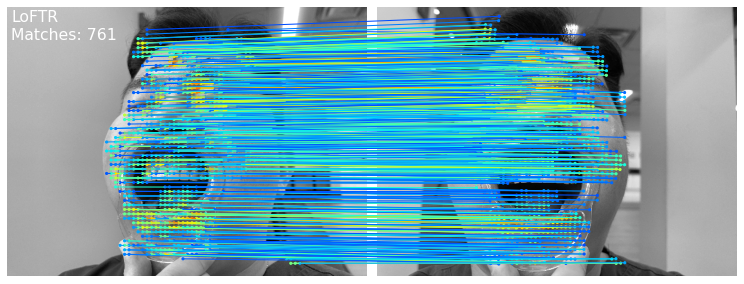

In [42]:
# Draw
color = cm.jet(mconf)
# 0~1사이값으로 RGB를 표현하고
# 0이 파란색 1이 빨간색이라고 생각하면 됩니다.

text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)# , path='/home/h/LoFTR/test5')